### Without Target Network

Text(0.5, 1.0, 'Epsilon decay by episode')

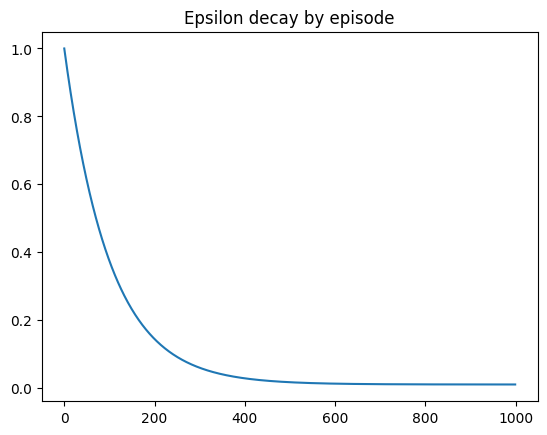

In [13]:
"""This DQN algorithm on MountainCar problem is implemented by Yinyu Jin. 
It is inspired by https://github.com/higgsfield/RL-Adventure"""

import gym
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

env = gym.make("MountainCar-v0")  
env = env.unwrapped

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # State: (array([-0.42279488,  0.        ], dtype=float32), {})   元组
        # Next State: [-4.2253944e-01  2.5544164e-04]     数组
        # State type: <class 'tuple'>
        # Next State type: <class 'numpy.ndarray'>

        # 确保 state 和 next_state 都是 NumPy 数组
        if isinstance(state, tuple):
            state = state[0]
        if isinstance(next_state, tuple):
            next_state = next_state[0]
            
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)
     
    
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 100

epsilon_by_epi = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * episode / epsilon_decay)


plt.plot([epsilon_by_epi(i) for i in range(1000)])
plt.title('Epsilon decay by episode')

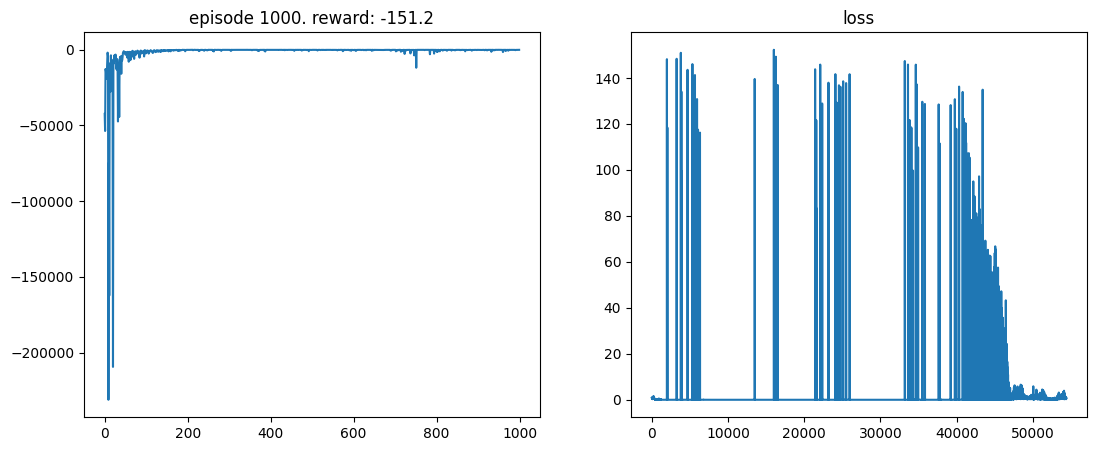

In [14]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    """epsilon-greedy action"""
    def act(self, state, epsilon):
        if random.random() > epsilon:
            q_value = self.forward(torch.Tensor(state))
            action  = torch.argmax(q_value).data.item()
        else:
            action = random.randrange(env.action_space.n)
        return action

model = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(20000)

def update_policy(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.Tensor(np.float32(state))
    next_state = torch.Tensor(np.float32(next_state)).detach()
    
    action     = torch.LongTensor(action)
    reward     = torch.Tensor(reward)
    done       = torch.Tensor(done)

    q_value      = model(state).gather(dim=1, index = action.unsqueeze(1)).squeeze(1)
    next_q_value = model(next_state).max(1)[0]

    target_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - target_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss


def plot(episode, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

    
num_episodes = 1000
batch_size = 64
gamma      = 0.99

losses = []
all_rewards = []
global_count =0 

for episode in range(1, num_episodes + 1):  
    state = env.reset()
    '''
    (1)以前（在 Gym 0.26之前）：env.reset() 通常会返回一个 NumPy 数组，表示环境的初始状态。
    (2)现在（从 Gym 0.26开始）：env.reset() 可能会返回一个元组，其中第一个元素是状态数组，后面可能跟随其他信息（如 info 字典），如(state, info)结构。
       其中 state 是 NumPy 数组，而 info 是一个字典，包含了关于初始状态的额外信息。但是需要的只是state
    '''
    # 兼容性处理
    if isinstance(state, tuple):
        state = state[0]
    
    episode_reward = 0
    
    while True: 
        global_count +=1
        epsilon = epsilon_by_epi(episode)
        action = model.act(state, epsilon)

        next_state, reward, done, _, info = env.step(action)
        # 兼容性处理
        if isinstance(next_state, tuple):
            next_state = next_state[0]
            
        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        
        if (len(replay_buffer) > batch_size) & (global_count % 30 == 0) :
            loss = update_policy(batch_size)
            losses.append(loss.data.item())  

        if done:
            all_rewards.append(episode_reward)
            
            break
             
    if episode % 10 == 0:
        plot(episode, all_rewards, losses)


### Add Target Network

Text(0.5, 1.0, 'Epsilon decay by episode')

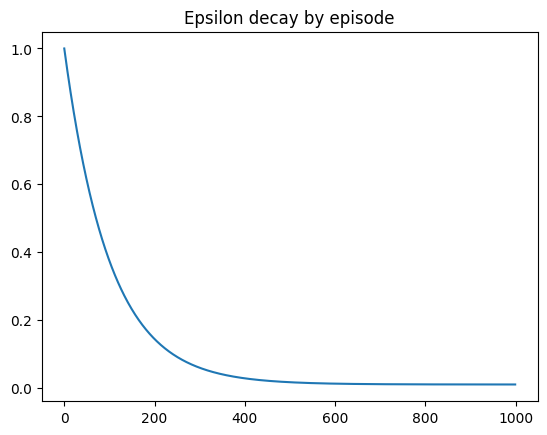

In [11]:
"""This DQN algorithm on MountainCar problem is implemented by Yinyu Jin. """

import gym
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

env = gym.make("MountainCar-v0")  
env = env.unwrapped

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # 确保 state 和 next_state 都是 NumPy 数组
        if isinstance(state, tuple):
            state = state[0]
        if isinstance(next_state, tuple):
            next_state = next_state[0]
        
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)
     
    
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 100

epsilon_by_epi = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * episode / epsilon_decay)


plt.plot([epsilon_by_epi(i) for i in range(1000)])
plt.title('Epsilon decay by episode')

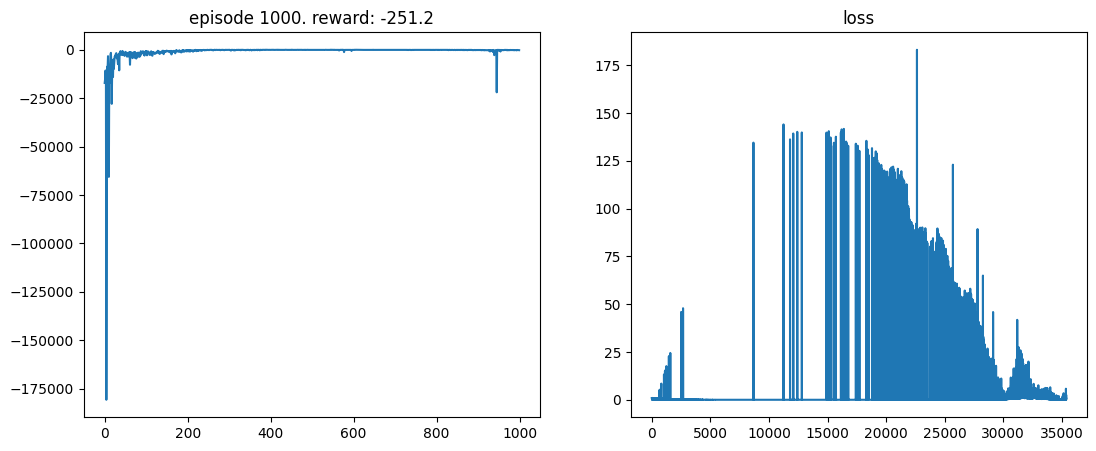

In [12]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, env.action_space.n)
        )
        
        self.learn_policy_counter =0
    
    def forward(self, x):
        return self.layers(x)
    
    # epsilon-greedy action
    def act(self, state, epsilon):
        if random.random() > epsilon:
            q_value = self.forward(torch.Tensor(state))
            action  = torch.argmax(q_value).data.item()
        else:
            action = random.randrange(env.action_space.n)
        return action

model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(20000)

def update_policy(batch_size):
    if model.learn_policy_counter % replace_target_iter ==0:
        target_model.load_state_dict(model.state_dict())
        
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.Tensor(np.float32(state))
    next_state = torch.Tensor(np.float32(next_state)).detach()
    action     = torch.LongTensor(action)
    reward     = torch.Tensor(reward)
    done       = torch.Tensor(done)

    q_value      = model(state).gather(dim=1, index = action.unsqueeze(1)).squeeze(1)
    next_q_value = target_model(next_state).max(1)[0]

    target_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - target_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.learn_policy_counter +=1
    
    return loss


def plot(episode, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

num_episodes = 1000
batch_size = 64
gamma      = 0.99
replace_target_iter = 30


losses = []
all_rewards = []
global_count =0 

for episode in range(1, num_episodes + 1):  
    state = env.reset()
    # 兼容性处理
    if isinstance(state, tuple):
        state = state[0]
    episode_reward = 0
    
    while True: 
        global_count +=1
        epsilon = epsilon_by_epi(episode)
        action = model.act(state, epsilon)

        next_state, reward, done, _, info = env.step(action)
        if isinstance(next_state, tuple):
            next_state = next_state[0]
    
        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        
        if (len(replay_buffer) > batch_size) & (global_count % 30 == 0) :
            loss = update_policy(batch_size)
            losses.append(loss.data.item())  

        if done:
            all_rewards.append(episode_reward)
            
            break
             
    if episode % 1 == 0:
        plot(episode, all_rewards, losses)
